# Problem Description: Burger's Equation

Governing equation $$u_t + uu_x = vu_{xx}, \quad x\in [-1,1],\quad t>0$$
where $ \nu=0.01 \pi$

Initial Condition: $$u(x,0) = -sin(\pi x)$$
Boundary Condition: $$u(-1,t)=u(1,t)=0$$


In [19]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import os
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
from neuralop.data.datasets import Burgers1dTimeDataset, PTDataset
from neuralop.data.transforms.data_processors import DefaultDataProcessor
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

torch.manual_seed(42)
np.random.seed(42)

Using device: cuda:0


In [ ]:
# 데이터셋 생성 및 로더 설정
dataset = Burgers1dTimeDataset(
    root_dir="C:/Users/admin/Desktop/김도형/코드/Dataset",
    n_train=500, n_tests=[20],
    train_resolution=16, test_resolutions=[16],
    batch_size=50, test_batch_sizes=[20]
)

data_processor = dataset.data_processor

train_loader = DataLoader(dataset.train_db, batch_size=50, shuffle=True, num_workers=2, pin_memory=True)
test_loaders = DataLoader(dataset.test_dbs[16], batch_size=20, shuffle=False, num_workers=2, pin_memory=True) 

batch = next(iter(train_loader))
batch = data_processorpreprocess.(batch, batched=True)
batch = {k: (v.to(device) if torch.is_tensor(v) else v) for k, v in batch.items()}

print("Processed x:", batch["x"].shape)
print("Processed y:", batch["y"].shape)

Loading test db for resolution 16 with 20 samples 


c:\Users\admin\AppData\Local\anaconda3\envs\py311\Lib\site-packages\neuralop\data\datasets\pt_dataset.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load

Processed x: torch.Size([50, 1, 17, 16])
Processed y: torch.Size([50, 1, 17, 16])


In [21]:
branch_u = batch["x"]
branch_v = batch["y"]

print(f'branch_u shape: {branch_u.shape}, branch_v shape: {branch_v.shape}')

branch_u shape: torch.Size([50, 1, 17, 16]), branch_v shape: torch.Size([50, 1, 17, 16])


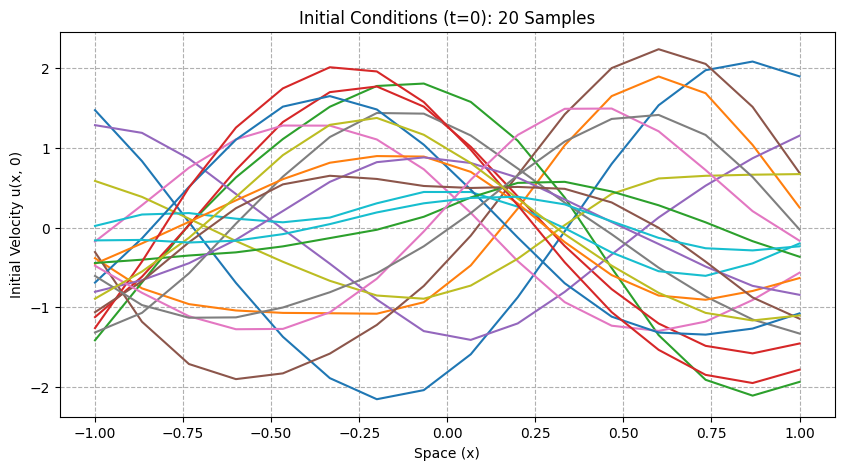

In [22]:
xs = torch.linspace(-1, 1, 16)
branch_raw = branch_u.detach().cpu()

plt.figure(figsize=(10, 5))

# 3. 샘플 시각화 (t=0 시점의 데이터만 추출)
num_samples = min(20, branch_raw.shape[0])

for i in range(num_samples):
    sample = branch_raw[i].squeeze() 
    u_initial = sample[0, :] # 첫 번째 시간(t=0)의 공간 데이터 16개 선택
    plt.plot(xs.numpy(), u_initial.numpy())

plt.xlabel("Space (x)")
plt.ylabel("Initial Velocity u(x, 0)")
plt.title(f"Initial Conditions (t=0): {num_samples} Samples")
plt.grid(True, linestyle='--')

# 4. 저장 및 출력
save_path = "C:/Users/admin/Desktop/김도형/코드/figure_20260227_labmeeting/FNO_Burgers_input.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

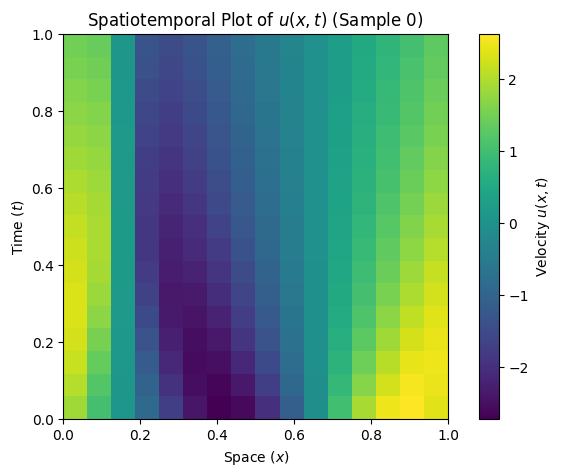

In [30]:
sample_0 = branch_v[0].detach().cpu().squeeze().numpy() 

xs = torch.linspace(0, 1, 16)
ts = torch.linspace(0, 1, 17)

plt.figure(figsize=(8, 5))
plt.imshow(sample_0, extent=[xs[0], xs[-1], ts[-1], ts[0]], cmap='viridis')
plt.colorbar(label='Velocity $u(x, t)$')

plt.xlabel("Space ($x$)")
plt.ylabel("Time ($t$)")
plt.title("Spatiotemporal Plot of $u(x, t)$ (Sample 0)")
plt.gca().invert_yaxis() # 시간이 아래에서 위로 흐르도록 설정
save_path = "C:/Users/admin/Desktop/김도형/코드/figure_20260227_labmeeting/FNO_Burgers_output.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

In [25]:
def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['lrelu', 'LReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus(beta=4)
    elif name in ['celu', 'CeLU']:
        return nn.CELU()
    elif name in ['elu']:
        return nn.ELU()
    elif name in ['mish']:
        return nn.Mish()
    else:
        raise ValueError('Unknown activation function')


In [ ]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.complex64))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.complex64))

    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x, y), (in_channel, out_channel, x, y) -> (batch, out_channel, x, y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft2(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.complex64, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9 
        
        # 입력 데이터(batch["x"])의 채널이 1이므로 Linear 입력층을 1로 설정
        self.p = nn.Linear(1, self.width) 
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
            
        self.q = nn.Linear(self.width, 128)
        self.fc = nn.Linear(128, 1) # 최종 출력 채널 1

    def forward(self, x):
        # x shape: [batch, 1, 17, 16] -> FNO는 보통 [batch, x, y, channel] 순서를 선호함
        x = x.permute(0, 2, 3, 1) # [batch, 17, 16, 1]
        x = self.p(x)
        x = x.permute(0, 3, 1, 2) # [batch, width, 17, 16]
        
        # 경계 효과 감소를 위한 패딩
        x = F.pad(x, [0, self.padding, 0, self.padding]) 

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding, :-self.padding] # 패딩 제거
        x = x.permute(0, 2, 3, 1) # [batch, 17, 16, width]
        x = self.q(x)
        x = F.gelu(x)
        x = self.fc(x)
        x = x.permute(0, 3, 1, 2) # 최종 출력: [batch, 1, 17, 16]
        return x

In [27]:
# 모델 초기화 시 float32로 명시 (이미 기본값이지만 확실히 하기 위해)
model = FNO2d(modes1=8, modes2=8, width=64).to(device).float()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()

epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        # 1. 데이터 전처리
        batch = data_processor.preprocess(batch, batched=True)
        
        # 2. .float()를 사용하여 Double(float64)을 Float(float32)로 변환
        x_train = batch["x"].to(device).float() 
        y_train = batch["y"].to(device).float() 

        optimizer.zero_grad()
        
        # 3. 모델 순전파
        out = model(x_train)
        
        # 4. 손실 계산 (out과 y_train 모두 float32여야 함)
        loss = criterion(out, y_train)
        
        # 이제 데이터 타입이 일치하므로 에러 없이 역전파가 수행됩니다.
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {train_loss/len(train_loader):.6f}")
        torch.save(model.state_dict(), "C:/Users/admin/Desktop/김도형/코드/model/burgers1d_fno_save.pt")

Epoch 0, Loss: 0.698903
Epoch 10, Loss: 0.002417
Epoch 20, Loss: 0.001306
Epoch 30, Loss: 0.000995
Epoch 40, Loss: 0.000783


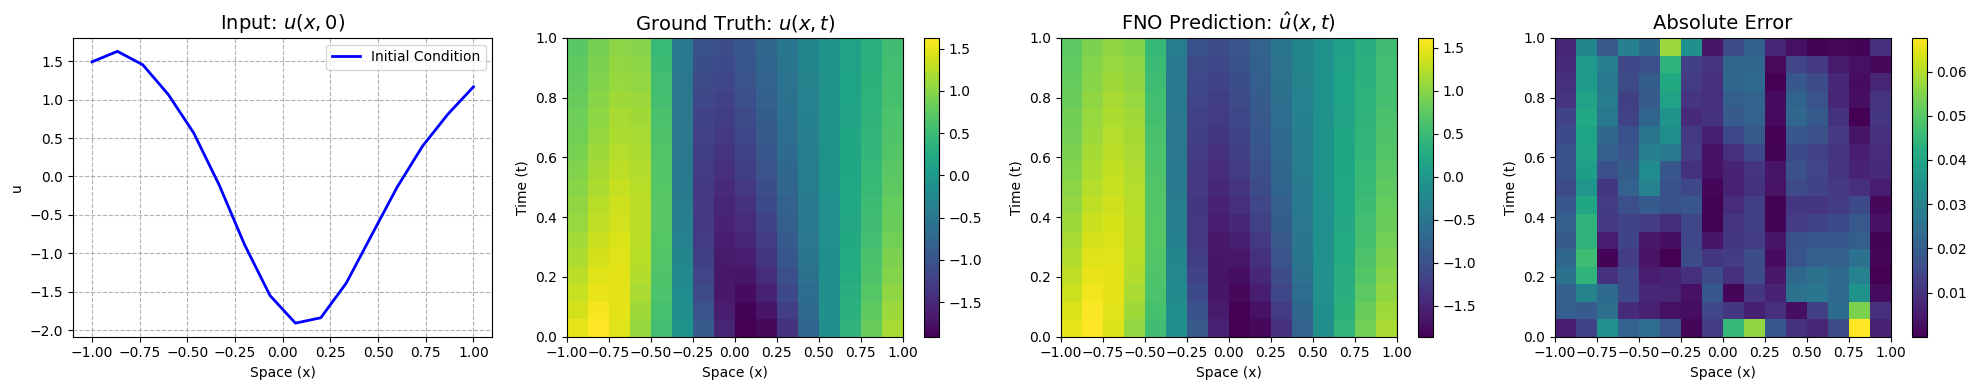

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_fno_results_horizontal(model, test_loader, device, data_processor):
    model.eval()
    
    # 1. 테스트 데이터 로드 및 전처리
    batch = next(iter(test_loader))
    batch = data_processor.preprocess(batch, batched=True)
    x_test = batch["x"].to(device).float()
    y_test = batch["y"].to(device).float()
    
    # 2. 모델 추론
    with torch.no_grad():
        prediction = model(x_test)
    
    # 3. 데이터 준비 (idx=0)
    truth = y_test[0, 0].cpu().numpy()
    pred = prediction[0, 0].cpu().numpy()
    initial_condition = truth[0, :]
    error = np.abs(truth - pred)
    
    nt, nx = truth.shape
    x_grid = np.linspace(-1, 1, nx)
    t_grid = np.linspace(0, 1, nt)
    extent = [x_grid[0], x_grid[-1], t_grid[0], t_grid[-1]]
    
    # 4. 시각화 (1행 4열 구성)
    # figsize를 가로로 길게(20), 세로를 짧게(5) 설정합니다.
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    
    # (1) 입력 초기 조건 u(x, 0)
    axes[0].plot(x_grid, initial_condition, 'b-', lw=2, label='Initial Condition')
    axes[0].set_title(r"Input: $u(x, 0)$", fontsize=14)
    axes[0].set_xlabel("Space (x)")
    axes[0].set_ylabel("u")
    axes[0].grid(True, linestyle='--')
    axes[0].legend()
    
    # (2) 실제 값 u(x, t)
    im1 = axes[1].imshow(truth, extent=extent, aspect='auto', origin='lower', cmap='viridis')
    axes[1].set_title(r"Ground Truth: $u(x, t)$", fontsize=14)
    axes[1].set_xlabel("Space (x)")
    axes[1].set_ylabel("Time (t)")
    fig.colorbar(im1, ax=axes[1])
    
    # (3) 모델 예측값 u(x, t)
    im2 = axes[2].imshow(pred, extent=extent, aspect='auto', origin='lower', cmap='viridis')
    axes[2].set_title(r"FNO Prediction: $\hat{u}(x, t)$", fontsize=14)
    axes[2].set_xlabel("Space (x)")
    axes[2].set_ylabel("Time (t)")
    fig.colorbar(im2, ax=axes[2])
    
    # (4) 절대 오차 히트맵
    im3 = axes[3].imshow(error, extent=extent, aspect='auto', origin='lower', cmap='viridis')
    axes[3].set_title("Absolute Error", fontsize=14)
    axes[3].set_xlabel("Space (x)")
    axes[3].set_ylabel("Time (t)")
    fig.colorbar(im3, ax=axes[3])
    
    plt.tight_layout()
    save_path = "C:/Users/admin/Desktop/김도형/코드/figure_20260227_labmeeting/FNO_Burgers_result.png"
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# 실행 (인덱싱 오류가 나지 않도록 test_loaders만 전달)
visualize_fno_results_horizontal(model, test_loaders, device, data_processor)